In [243]:
import itertools
from pathlib import Path

import geowombat as gw
# from tsplanet import download_data

import numpy as np
import sklearn_crfsuite
import matplotlib.pyplot as plt

## Download PlanetScope data

In [2]:
# download_data('/scratch/rsc4/graesser/temp/planet',
#               '/export/home/graesserj/code/python/github/planet/tsplanet/geojson/qld.geojson',
#               '2019-08-01', 
#               '2019-08-10',
#               cloud_cover=0.8,
#               api_key='des')

## Extract samples from training AOIs

In [3]:
planet_dir = Path('/scratch/rsc4/graesser/temp/planet')

In [384]:
filenames = ['20190802_234446_0f31_3B_AnalyticMS_SR',
             '20190804_234646_100a_3B_AnalyticMS_SR', 
             '20190809_234600_104a_3B_AnalyticMS_SR',
             '20190809_234852_0f2a_3B_AnalyticMS_SR',
             '20190812_234445_1005_3B_AnalyticMS_SR']

In [385]:
rasters = [planet_dir.joinpath(fn + '.tif').as_posix() for fn in filenames]
vectors = [planet_dir.joinpath('training').joinpath(fn + '.shp').as_posix() for fn in filenames]

### Plot the intersection

In [ ]:
with gw.config.update(ref_image=rasters[0], sensor='planetscope'):
    
    with gw.open(rasters,
                 how='intersection') as ds:
        
        dss = ds.mean(dim='time')
        dss.attrs = ds.attrs
        
        dss.gw.imshow(band_names=['red', 'green', 'blue'], nodata=0, robust=True)

<IPython.core.display.Javascript object>

### Extract samples

In [387]:
dfs = list()

In [388]:
with gw.config.update(ref_image=rasters[0], sensor='planetscope'):
    
    for raster, vector in zip(rasters, vectors):
        
        with gw.open(raster) as ds:
            dfs.append(ds.gw.extract(vector, frac=0.5))

100%|██████████| 4/4 [00:00<00:00, 66.54it/s]


In [389]:
dfs[0].head()

,poly,point,geometry,blue,green,red,nir
0,1,0,POINT (233496.000 7064016.000),346,492,603,1753
1,1,1,POINT (233415.000 7064040.000),441,629,820,1674
2,1,2,POINT (233343.000 7064010.000),521,668,901,1755
3,1,3,POINT (233319.000 7063977.000),585,769,986,1793
4,1,4,POINT (233433.000 7063968.000),412,573,723,1755


In [390]:
dfs[2].poly.unique()

array([1, 4])

## Convert samples to CRF features

In [391]:
band_names = ['blue', 'green', 'red', 'nir']
label_name = 'poly'
label_dict = {0: 'nodata', 1: 'land', 2: 'water', 3: 'cloud', 4: 'shadow'}

In [392]:
def label_decoder(label):
    return label_dict[label]


def get_sample_xy(sample):
    return dict(zip(band_names, np.float64(sample[band_names].values))), label_decoder(int(sample.poly))


def get_array_xy(sample):
    return dict(zip(band_names, sample))

    
def samples_to_features(dfs):
    
    """
    sample = [[{t1}, {t2}, ..., {tn}], ..., [...]]
    """
    
    return [list(zip(*df.apply(get_sample_xy, axis=1))) for df in dfs]


def array_to_dict(*args):
    return [dict(zip(band_names, sample)) for sample in args]

In [393]:
results = samples_to_features(dfs)

### CRF X and y

In [394]:
X = np.array(list(zip(*results))[0]).T.tolist()
print(len(X))

4482


In [395]:
y = np.array(list(zip(*results))[1]).T.tolist()
print(len(y))

4482


### Fit the model

In [396]:
model = sklearn_crfsuite.CRF(algorithm='lbfgs', # Gradient descent using the limited-memory BFGS method (with L1 and L2 regularization)
            c1=0.001,
            c2=0.001,
            max_iterations=5000,
            num_memories=10,
            period=10,
            epsilon=1e-06,
            delta=1e-06,
            linesearch='StrongBacktracking    ',  # 'MoreThuente' 'Backtracking' 'StrongBacktracking'
            max_linesearch=20,
            all_possible_states=True,
            all_possible_transitions=True,
            verbose=False)

In [397]:
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    averaging=None, c=None, c1=0.001, c2=0.001, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=1e-06, epsilon=1e-06, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch='StrongBacktracking    ',
    max_iterations=5000, max_linesearch=20, min_freq=None, model_filename=None,
    num_memories=10, pa_type=None, period=10, trainer_cls=None, variance=None,
    verbose=False)

In [398]:
model.predict_marginals(X)[0]

[{'land': 0.9999999999999999,
  'cloud': 1.482568602172576e-28,
  'shadow': 1.4226956066922163e-20,
  'nodata': 3.2584148093990943e-38},
 {'land': 1.0,
  'cloud': 8.747325929055392e-38,
  'shadow': 2.0169983995129786e-24,
  'nodata': 3.5945677166143243e-32},
 {'land': 0.9999942944226522,
  'cloud': 5.705433066785652e-06,
  'shadow': 1.4428100720139802e-10,
  'nodata': 3.0673315988038434e-24},
 {'land': 8.766561939616248e-11,
  'cloud': 0.9999999999123107,
  'shadow': 2.3615039610486863e-14,
  'nodata': 7.598525068702494e-42},
 {'land': 0.9999999999999992,
  'cloud': 7.144371202386597e-16,
  'shadow': 1.1752756157105533e-24,
  'nodata': 2.5428740511224292e-39}]

In [399]:
# samples x time x n classes
# pred = np.array([[[ps['land'], ps['cloud']] for ps in p] for p in model.predict_marginals(X)], dtype='float64')

In [400]:
# pred.shape

### Open the data to predict on 

In [430]:
with gw.config.update(ref_image=rasters[0], sensor='planetscope'):
    
    with gw.open(rasters,
                 how='intersection') as ds:
        
        dss = gw.subset(ds, left=231944.279, top=7064752.344, rows=500, cols=500)
        test = dss.astype('float64').data.compute()

In [431]:
ntime, nbands, nrows, ncols = test.shape
nclasses = 4

In [432]:
# X[0]

### Convert the array to CRF-compatible features

In [433]:
# array_to_dict(test[0].transpose(1, 2, 0).reshape(nrows*ncols, nbands)[0],
#               test[1].transpose(1, 2, 0).reshape(nrows*ncols, nbands)[0])

In [434]:
features = [tlayer.transpose(1, 2, 0).reshape(nrows*ncols, nbands) for tlayer in test]
features = [array_to_dict(*[features[j][i] for j in range(0, ntime)]) for i in range(0, nrows*ncols)]

In [435]:
features[0]

[{'blue': 690.0, 'green': 924.0, 'red': 1136.0, 'nir': 2074.0},
 {'blue': 532.0, 'green': 765.0, 'red': 1050.0, 'nir': 2166.0},
 {'blue': 894.0, 'green': 976.0, 'red': 1155.0, 'nir': 1967.0},
 {'blue': 794.0, 'green': 828.0, 'red': 1028.0, 'nir': 1824.0},
 {'blue': 751.0, 'green': 935.0, 'red': 1164.0, 'nir': 2032.0}]

### Predict on all time steps

In [436]:
# samples x time x n classes
pred = np.array([[[ps['nodata'], ps['land'], ps['cloud'], ps['shadow']] for ps in p] 
                 for p in model.predict_marginals(features)], dtype='float64')

In [437]:
pred[0]

array([[3.73296814e-48, 1.00000000e+00, 1.10937083e-20, 2.11020096e-27],
       [7.71219675e-44, 1.00000000e+00, 1.67321419e-36, 1.71583122e-29],
       [1.05841355e-32, 9.99999893e-01, 1.07276642e-07, 1.92553690e-12],
       [1.46976921e-29, 1.00000000e+00, 3.43143156e-11, 1.18724010e-11],
       [3.80136552e-42, 1.00000000e+00, 3.87030851e-18, 7.44981288e-28]])

In [438]:
pred.shape

(250000, 5, 4)

In [439]:
pred = pred.transpose(1, 2, 0).reshape(ntime, nclasses, nrows, ncols)

In [440]:
pred.shape

(5, 4, 500, 500)

## Plot cloud probabilities

<IPython.core.display.Javascript object>


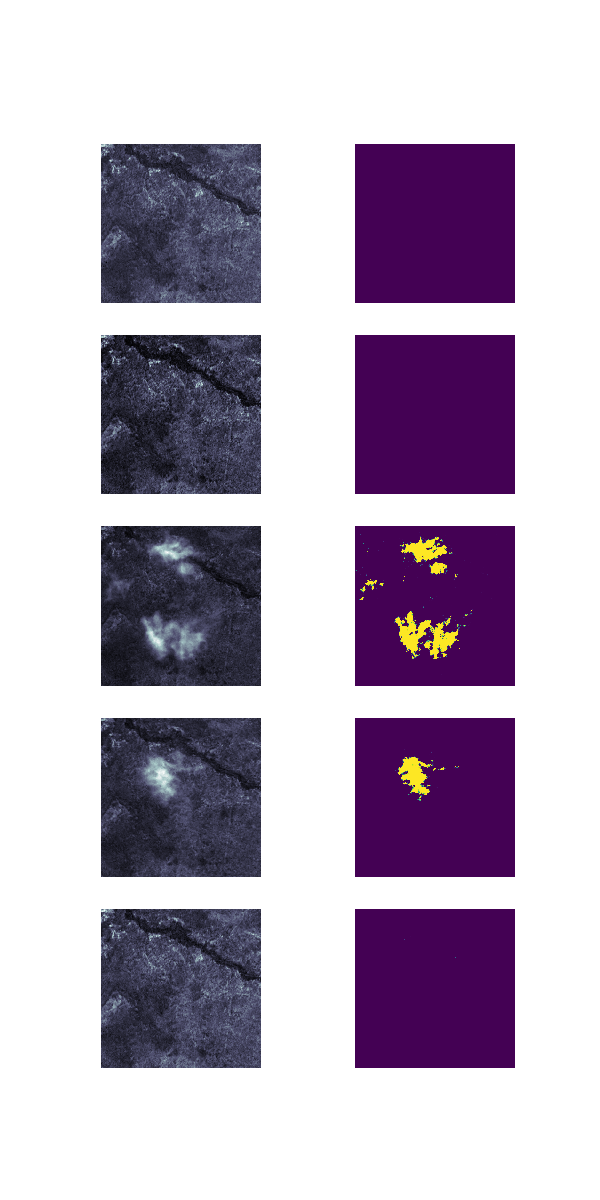

In [441]:
%matplotlib notebook

fig, axes = plt.subplots(5, 2, dpi=200, figsize=(3, 6))

bidx = 0 # band index
cidx = 2 # class index

for pi in range(0, pred.shape[0]):

    axes[pi][0].imshow(test[pi, bidx, :, :], cmap='bone')
    axes[pi][1].imshow(pred[pi, cidx, :, :])
    
#     axes[pi][0].set_xlabel('Time {:d}'.format(pi+1))
    
    axes[pi][0].axis('off')
    axes[pi][1].axis('off')

plt.show()

### Shape testing

In [176]:
# a = np.arange(8*3*2).reshape(8,3,2)

In [217]:
# time 1
# a[:, 0, :]

In [218]:
# time 2
# a[:, 1, :]

In [219]:
# a.transpose(1, 2, 0).reshape(3, 2, 2, 4)[1]